## Лабораторная работа № 2. Exploratory Data Analysis и линейная регрессия


### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
# !pip install folium

In [ ]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

## Часть 0. Подготовка

**Задание 1**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/nyc_taxi_trip_duration.csv')
data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848
...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [ ]:
data = data.drop(columns=['dropoff_datetime'])
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

<Axes: xlabel='trip_duration', ylabel='Count'>

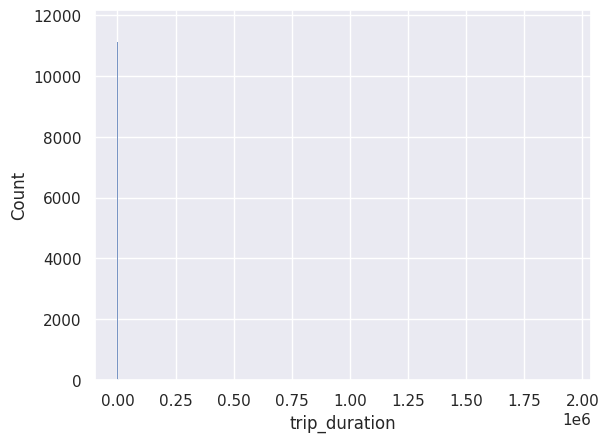

In [ ]:
sns.histplot(data['trip_duration'])

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

<Axes: xlabel='log_trip_duration', ylabel='Count'>

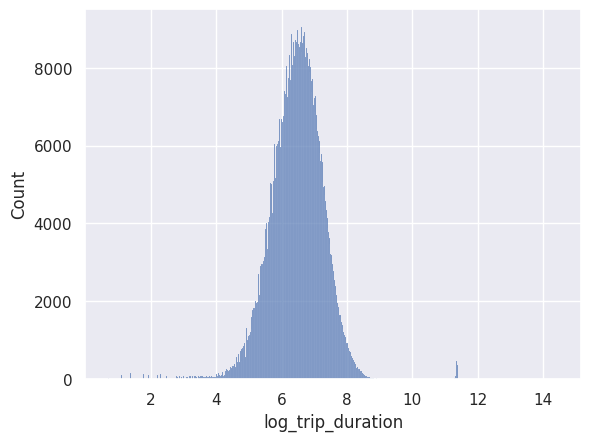

In [ ]:
data['log_trip_duration'] = np.log1p(data['trip_duration'])
data = data.drop(columns=['trip_duration'])

sns.histplot(data['log_trip_duration'])

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X, y = data.loc[:,:'store_and_fwd_flag'], data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

dr = DummyRegressor(strategy='constant', constant=6)

dr.fit(X_train, y_train)

y_pred = dr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Среднеквадратичная ошибка константного предсказания:", mse)
print(f'R2 score: {r2_score(y_test, y_pred)}')

Среднеквадратичная ошибка константного предсказания: 0.8553818705322748
R2 score: -0.33642410174291304


## Часть 1. Изучаем `pickup_datetime`

**Задание 2**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [ ]:
data['day_of_year'] = data['pickup_datetime'].dt.dayofyear

daily_trips = data.groupby('day_of_year').size().reset_index(name='counts')

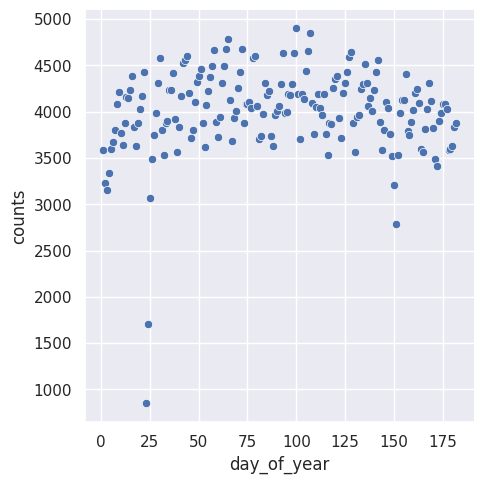

In [ ]:
sns.relplot(daily_trips, x='day_of_year', y='counts')

<Axes: xlabel='day_of_year', ylabel='count'>

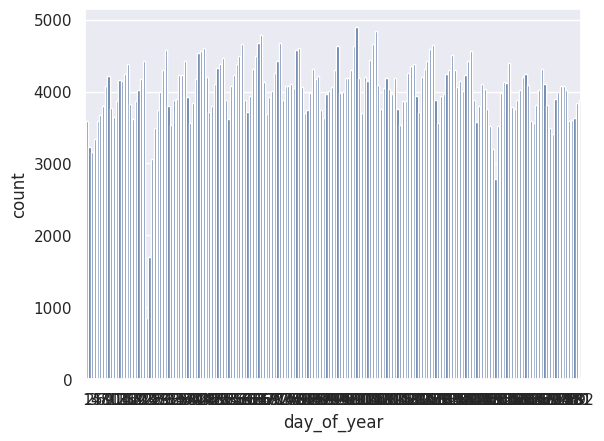

In [ ]:
sns.countplot(data, x='day_of_year')

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [ ]:
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['hour_of_day'] = data['pickup_datetime'].dt.hour

dow_trips = data.groupby('day_of_week').size().reset_index(name='counts')
hod_trips = data.groupby('hour_of_day').size().reset_index(name='counts')

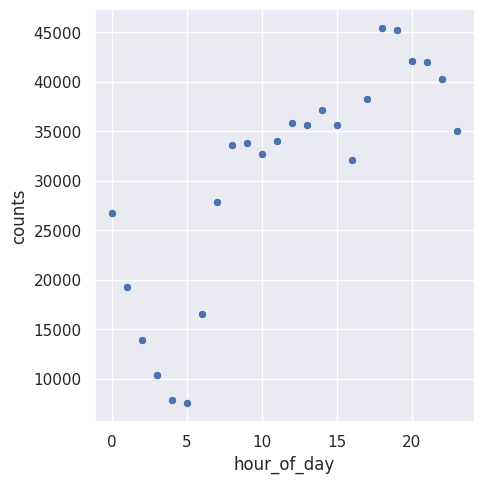

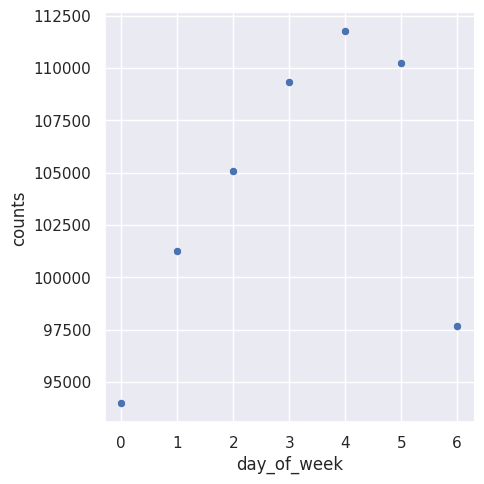

In [ ]:
sns.relplot(hod_trips, x='hour_of_day', y='counts')
sns.relplot(dow_trips, x='day_of_week', y='counts')

**Задание 3**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

Text(0, 0.5, 'Counts')

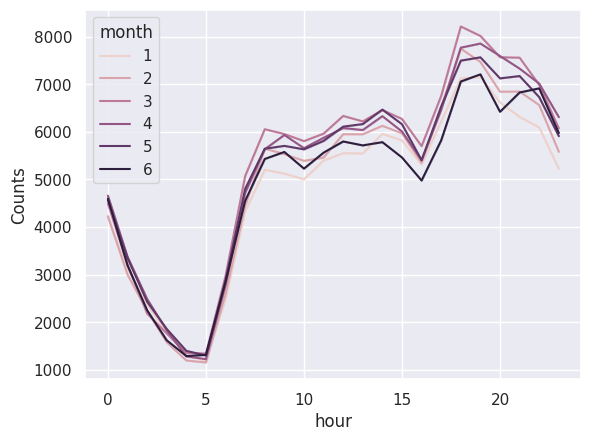

In [ ]:
data['hour'] = data['pickup_datetime'].dt.hour
data['month'] = data['pickup_datetime'].dt.month

sns.lineplot(x='hour', y=data.index, hue='month', estimator='size', data=data)
plt.ylabel('Counts')

In [ ]:
trip_counts = data.groupby(['hour', 'month']).size().reset_index(name='trip_count')

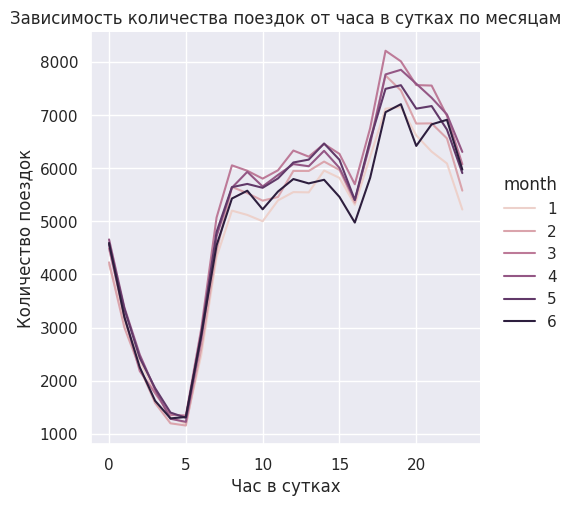

In [ ]:
sns.relplot(data=trip_counts, x='hour', y='trip_count', hue='month', kind='line')
plt.title('Зависимость количества поездок от часа в сутках по месяцам')
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.show()

In [ ]:
trip_counts = data.groupby(['hour', 'day_of_week']).size().reset_index(name='trip_count')

sns.relplot(data=trip_counts, x='hour', y='trip_count', hue='day_of_week', kind='line')
plt.title('Зависимость количества поездок от часа в сутках по дням недели')
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)

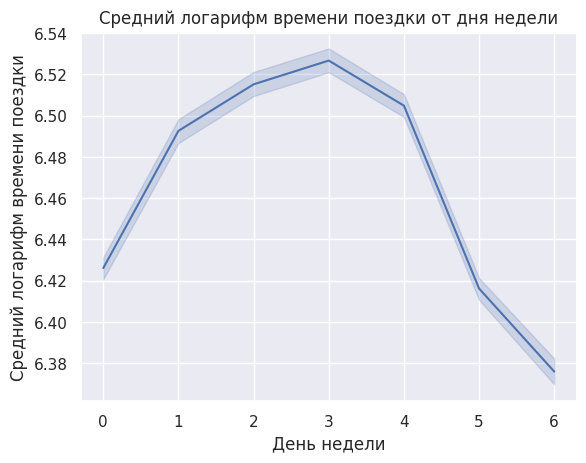

In [ ]:
sns.lineplot(x='day_of_week', y='log_trip_duration', data=train_df, estimator='mean')
plt.title('Средний логарифм времени поездки от дня недели')
plt.xlabel('День недели')
plt.ylabel('Средний логарифм времени поездки')
plt.show()

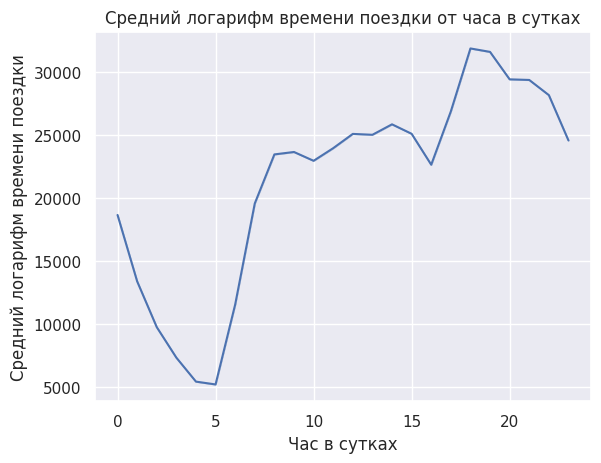

In [ ]:
sns.lineplot(x='hour', y='log_trip_duration', data=train_df, estimator='size')
plt.title('Средний логарифм времени поездки от часа в сутках')
plt.xlabel('Час в сутках')
plt.ylabel('Средний логарифм времени поездки')
plt.show()

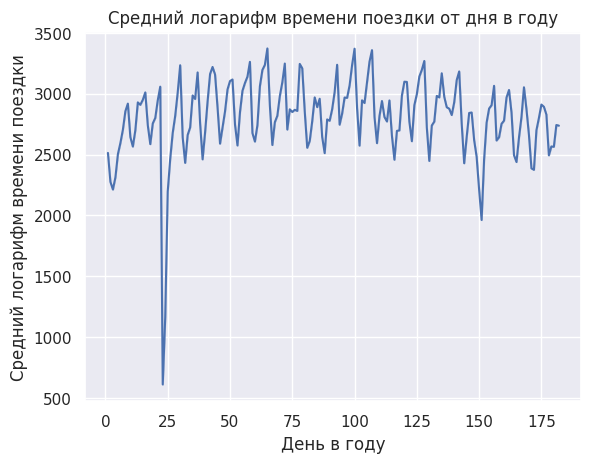

In [ ]:
sns.lineplot(x='day_of_year', y='log_trip_duration', data=train_df, estimator='size')
plt.title('Средний логарифм времени поездки от дня в году')
plt.xlabel('День в году')
plt.ylabel('Средний логарифм времени поездки')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  729322 non-null  object        
 1   vendor_id           729322 non-null  int64         
 2   pickup_datetime     729322 non-null  datetime64[ns]
 3   passenger_count     729322 non-null  int64         
 4   pickup_longitude    729322 non-null  float64       
 5   pickup_latitude     729322 non-null  float64       
 6   dropoff_longitude   729322 non-null  float64       
 7   dropoff_latitude    729322 non-null  float64       
 8   store_and_fwd_flag  729322 non-null  object        
 9   log_trip_duration   729322 non-null  float64       
 10  day_of_year         729322 non-null  int32         
 11  day_of_week         729322 non-null  int32         
 12  hour_of_day         729322 non-null  int32         
 13  hour                729322 no

In [ ]:
anomalous_period_1_start = pd.to_datetime('2016-05-26')
anomalous_period_1_end = pd.to_datetime('2016-05-30')
anomalous_period_2_start = pd.to_datetime('2016-01-23')
anomalous_period_2_end = pd.to_datetime('2016-01-24')

In [ ]:
data['is_anomalous_period_1'] = data['pickup_datetime'].apply(lambda x: 1 if (anomalous_period_1_start <= x <= anomalous_period_1_end) else 0)
data['is_anomalous_period_2'] = data['pickup_datetime'].apply(lambda x: 1 if (anomalous_period_2_start <= x <= anomalous_period_2_end) else 0)

In [ ]:
# df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
# df['month'] = df['pickup_datetime'].dt.month
# df['hour'] = df['pickup_datetime'].dt.hour
# df['day_of_year'] = df['pickup_datetime'].dt.dayofyear

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge

In [ ]:
X, y = data[['day_of_week', 'month', 'hour', 'day_of_year', 'is_anomalous_period_1', 'is_anomalous_period_2']], data['log_trip_duration']

In [ ]:
categorical_features = ['day_of_week', 'month', 'is_anomalous_period_1', 'is_anomalous_period_2']
numeric_features = ['hour', 'day_of_year']

encoder = OneHotEncoder()
scaler = StandardScaler()

X_encoded = encoder.fit_transform(X[categorical_features])
X_scaled = scaler.fit_transform(X[numeric_features])

In [ ]:
X_prepared = np.hstack((X_encoded.toarray(), X_scaled))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.3, random_state=42)

In [ ]:
model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [ ]:
# Прогнозы и оценка
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}\nR2 score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.6261751265055586
R2 score: 0.00795636508036679


## Часть 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
!pip install haversine

In [ ]:
from haversine import haversine, Unit

def calculate_haversine(row):
    start = (row['pickup_latitude'], row['pickup_longitude'])
    end = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(start, end, unit=Unit.KILOMETERS)

data['haversine'] = data.apply(calculate_haversine, axis=1)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [ ]:
data['log_haversine'] = np.log1p(data['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
corr = data[['log_haversine','haversine','log_trip_duration']].corr()
corr.style.background_gradient(cmap='RdYlGn')

,log_haversine,haversine,log_trip_duration
log_haversine,1.000000,0.833438,0.750514
haversine,0.833438,1.000000,0.566067
log_trip_duration,0.750514,0.566067,1.000000


**Задание 7**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

<Axes: xlabel='speed', ylabel='Count'>

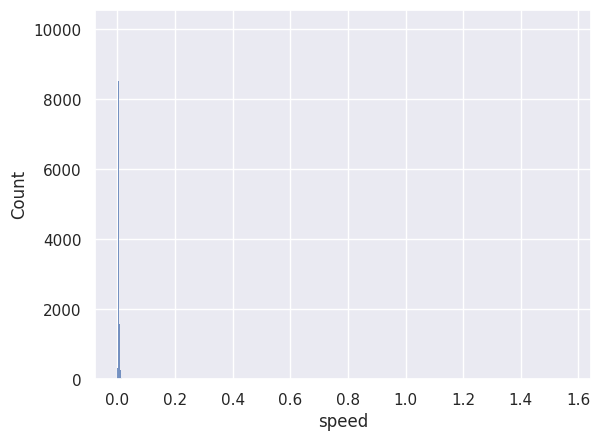

In [ ]:
data['speed'] = data['haversine'] / np.exp(data['log_trip_duration'])
sns.histplot(data['speed'])

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [ ]:
data['speed'].describe()

count    729322.000000
mean          0.003995
std           0.003361
min           0.000000
25%           0.002530
50%           0.003547
75%           0.004945
max           1.564830
Name: speed, dtype: float64

<Axes: xlabel='speed', ylabel='Count'>

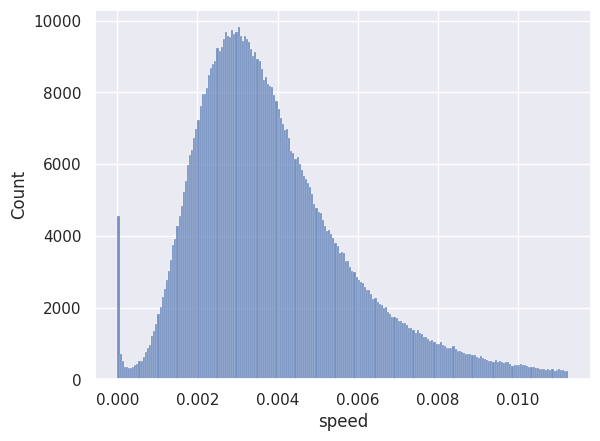

In [ ]:
reasonable_speed = data[data['speed'] < data['speed'].quantile(0.99)]
sns.histplot(reasonable_speed['speed'])

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<Axes: xlabel='hour_of_day', ylabel='day_of_week'>

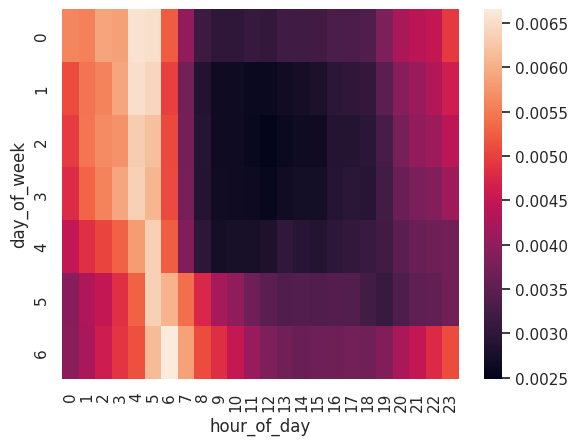

In [ ]:
median_speed = data.groupby(['day_of_week', 'hour_of_day'])['speed'].median().unstack()
sns.heatmap(median_speed, fmt=".1f")

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [ ]:
data = data.drop(columns=['speed'])

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [ ]:
data['is_rush_hour'] = ((data['hour_of_day'] >= 7) & (data['hour_of_day'] <= 9) |
                        (data['hour_of_day'] >= 16) & (data['hour_of_day'] <= 18)).astype(int)
data['is_free_road'] = ((data['hour_of_day'] < 7) | (data['hour_of_day'] > 18)).astype(int)

**Задание 8**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [ ]:
jfk_coords = (40.6413, -73.7781)
lga_coords = (40.7769, -73.8740)

def is_near_jfk(lat, lon):
    return haversine(lon, lat, jfk_coords[1], jfk_coords[0]) < 1

def is_near_lga(lat, lon):
    return haversine(lon, lat, lga_coords[1], lga_coords[0]) < 1

data['pickup_near_jfk'] = is_near_jfk(data['pickup_latitude'], data['pickup_longitude']).astype(int)
data['dropoff_near_jfk'] = is_near_jfk(data['dropoff_latitude'], data['dropoff_longitude']).astype(int)
data['pickup_near_lga'] = is_near_lga(data['pickup_latitude'], data['pickup_longitude']).astype(int)
data['dropoff_near_lga'] = is_near_lga(data['dropoff_latitude'], data['dropoff_longitude']).astype(int)

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

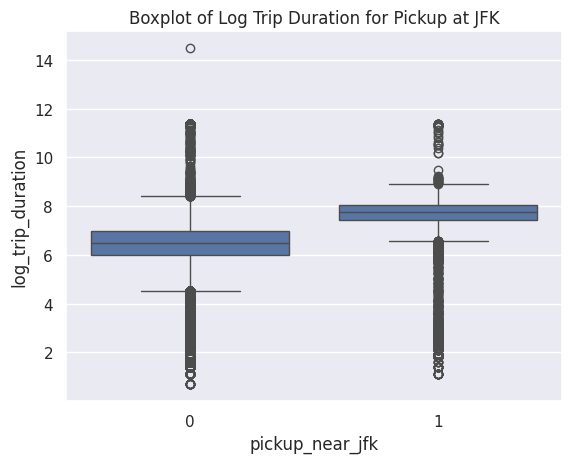

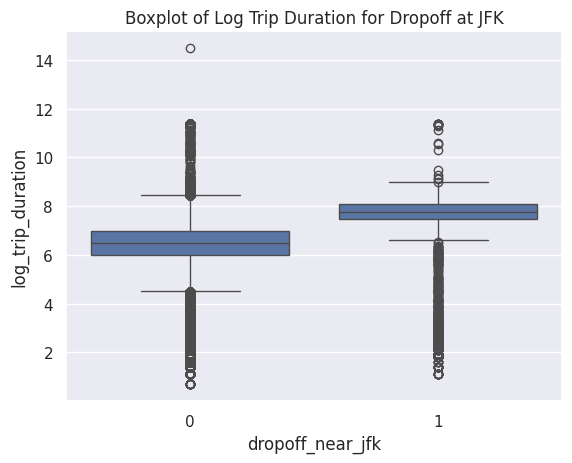

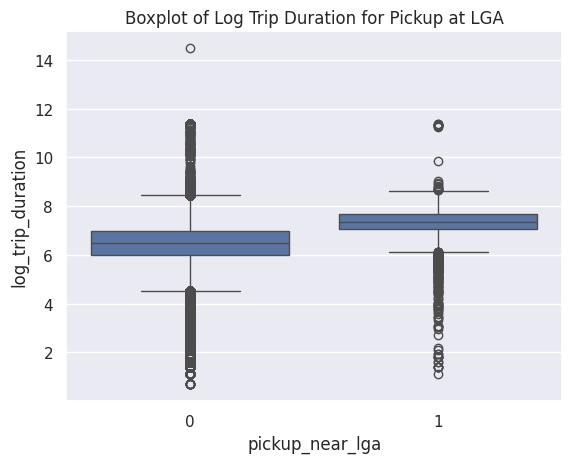

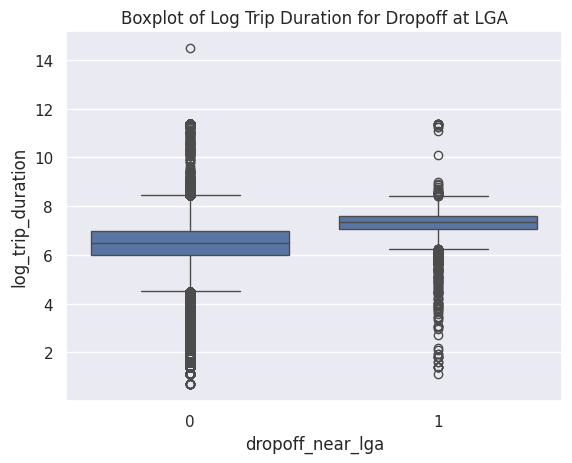

In [ ]:
sns.boxplot(x='pickup_near_jfk', y='log_trip_duration', data=data)
plt.title('Boxplot of Log Trip Duration for Pickup at JFK')
plt.show()

sns.boxplot(x='dropoff_near_jfk', y='log_trip_duration', data=data)
plt.title('Boxplot of Log Trip Duration for Dropoff at JFK')
plt.show()

sns.boxplot(x='pickup_near_lga', y='log_trip_duration', data=data)
plt.title('Boxplot of Log Trip Duration for Pickup at LGA')
plt.show()

sns.boxplot(x='dropoff_near_lga', y='log_trip_duration', data=data)
plt.title('Boxplot of Log Trip Duration for Dropoff at LGA')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows=10, n_cols=10):
        self.n_rows = n_rows
        self.n_cols = n_cols

    def fit(self, X, y=None):
        self.lat_min, self.lat_max = X['pickup_latitude'].min(), X['pickup_latitude'].max()
        self.lon_min, self.lon_max = X['pickup_longitude'].min(), X['pickup_longitude'].max()
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        lat_bins = np.linspace(self.lat_min, self.lat_max, self.n_rows + 1)
        lon_bins = np.linspace(self.lon_min, self.lon_max, self.n_cols + 1)

        X_transformed['pickup_grid'] = np.digitize(X['pickup_latitude'], lat_bins) * 100 + np.digitize(X['pickup_longitude'], lon_bins)
        X_transformed['dropoff_grid'] = np.digitize(X['dropoff_latitude'], lat_bins) * 100 + np.digitize(X['dropoff_longitude'], lon_bins)

        X_transformed['pickup_grid'] = X_transformed['pickup_grid'].replace({self.n_rows * 100 + self.n_cols + 1: -1})
        X_transformed['dropoff_grid'] = X_transformed['dropoff_grid'].replace({self.n_rows * 100 + self.n_cols + 1: -1})

        return X_transformed[['pickup_grid', 'dropoff_grid']]

In [ ]:
map_grid_transformer = MapGridTransformer(n_rows=20, n_cols=20)
map_grid_transformer.fit(data)
grid_data = map_grid_transformer.transform(data)

data = pd.concat([data, grid_data], axis=1)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     729322 non-null  object        
 1   vendor_id              729322 non-null  int64         
 2   pickup_datetime        729322 non-null  datetime64[ns]
 3   passenger_count        729322 non-null  int64         
 4   pickup_longitude       729322 non-null  float64       
 5   pickup_latitude        729322 non-null  float64       
 6   dropoff_longitude      729322 non-null  float64       
 7   dropoff_latitude       729322 non-null  float64       
 8   store_and_fwd_flag     729322 non-null  object        
 9   log_trip_duration      729322 non-null  float64       
 10  day_of_year            729322 non-null  int32         
 11  day_of_week            729322 non-null  int32         
 12  hour_of_day            729322 non-null  int3

In [ ]:
X, y = data[['day_of_week', 'month', 'hour', 'day_of_year',
             'is_anomalous_period_1', 'is_anomalous_period_2',
             'hour_of_day', 'log_haversine', 'is_rush_hour',
             'is_free_road', 'pickup_grid', 'dropoff_grid']], data['log_trip_duration']

In [ ]:
categorical_features = ['day_of_week', 'month', 'is_anomalous_period_1', 'is_anomalous_period_2',
                         'is_rush_hour', 'is_free_road', 'pickup_grid', 'dropoff_grid']
numeric_features = ['hour', 'day_of_year', 'hour_of_day', 'log_haversine']

encoder = OneHotEncoder()
scaler = StandardScaler()

X_encoded = encoder.fit_transform(X[categorical_features])
X_scaled = scaler.fit_transform(X[numeric_features])

In [ ]:
X_prepared = np.hstack((X_encoded.toarray(), X_scaled))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.3, random_state=42)

In [ ]:
model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}\nR2 score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.25341946791694653
R2 score: 0.5985098106424142


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
print(data['vendor_id'].nunique())
print(data['passenger_count'].nunique())
print(data['store_and_fwd_flag'].nunique())

2
9
2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

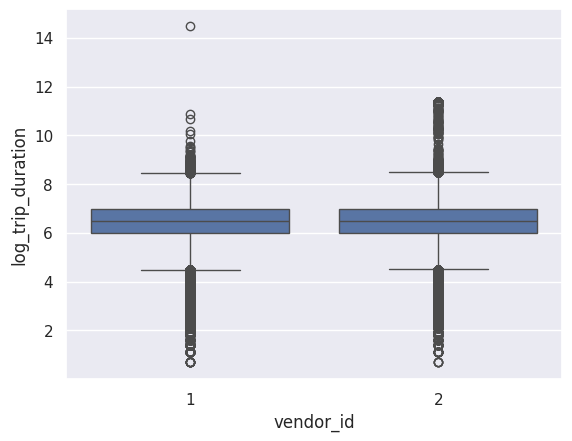

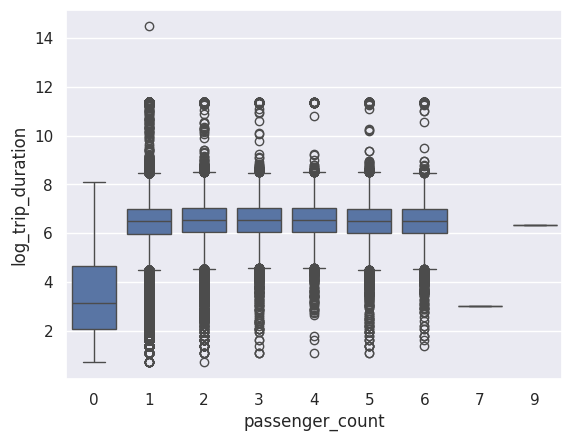

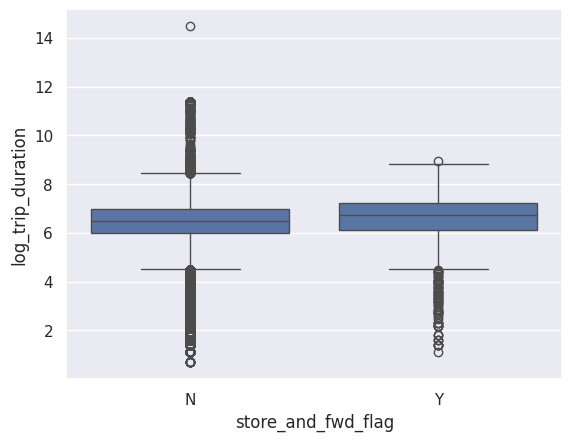

In [ ]:
sns.boxplot(x='vendor_id', y='log_trip_duration', data=data)
plt.show()

sns.boxplot(x='passenger_count', y='log_trip_duration', data=data)
plt.show()

sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=data)
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
data['vendor_id'] = data['vendor_id'].apply(lambda x: 1 if x == 2 else 0)
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].apply(lambda x: 1 if x == 'Y' else 0)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     729322 non-null  object        
 1   vendor_id              729322 non-null  int64         
 2   pickup_datetime        729322 non-null  datetime64[ns]
 3   passenger_count        729322 non-null  int64         
 4   pickup_longitude       729322 non-null  float64       
 5   pickup_latitude        729322 non-null  float64       
 6   dropoff_longitude      729322 non-null  float64       
 7   dropoff_latitude       729322 non-null  float64       
 8   store_and_fwd_flag     729322 non-null  int64         
 9   log_trip_duration      729322 non-null  float64       
 10  day_of_year            729322 non-null  int32         
 11  day_of_week            729322 non-null  int32         
 12  hour_of_day            729322 non-null  int3

In [ ]:
X, y = data[['day_of_week', 'month', 'hour', 'day_of_year',
             'is_anomalous_period_1', 'is_anomalous_period_2',
             'hour_of_day', 'log_haversine', 'is_rush_hour',
             'is_free_road', 'pickup_grid', 'dropoff_grid',
             'vendor_id', 'passenger_count', 'store_and_fwd_flag']], data['log_trip_duration']

In [ ]:
categorical_features = ['day_of_week', 'month', 'is_anomalous_period_1', 'is_anomalous_period_2',
                         'is_rush_hour', 'is_free_road', 'pickup_grid', 'dropoff_grid', 'vendor_id', 'store_and_fwd_flag']
numeric_features = ['hour', 'day_of_year', 'hour_of_day', 'log_haversine', 'passenger_count']

encoder = OneHotEncoder()
scaler = StandardScaler()

X_encoded = encoder.fit_transform(X[categorical_features])
X_scaled = scaler.fit_transform(X[numeric_features])

In [ ]:
X_prepared = np.hstack((X_encoded.toarray(), X_scaled))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.3, random_state=42)

In [ ]:
model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}\nR2 score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.2532355292657634
R2 score: 0.5988012229971977


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [ ]:
data = data.drop(columns=['vendor_id', 'passenger_count', 'store_and_fwd_flag'])

## Часть 4. Улучшаем модель

**Задание 13**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

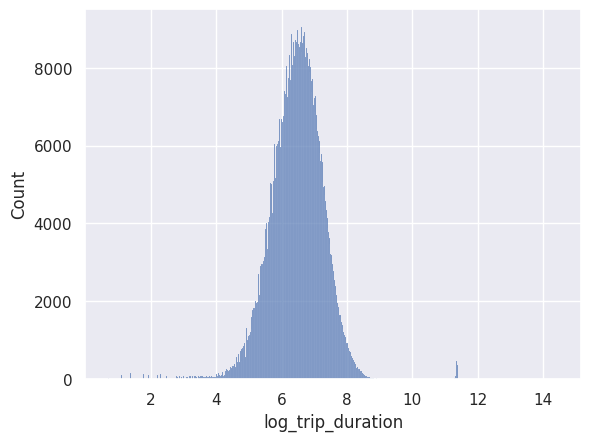

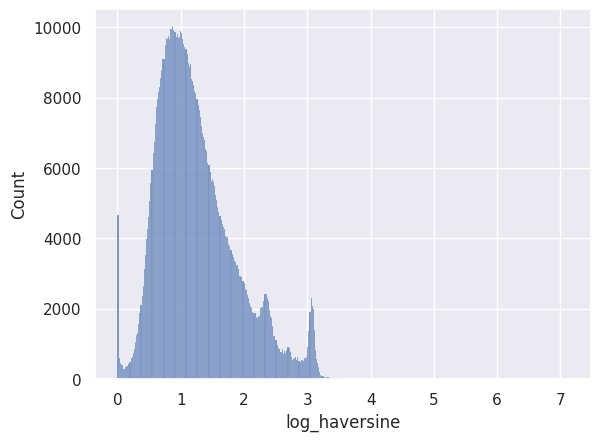

In [ ]:
sns.histplot(data['log_trip_duration'])
plt.show()

sns.histplot(data['log_haversine'])
plt.show()

In [ ]:
data_cleaned = data[(data['log_trip_duration'] < 10) &
                    (data['log_haversine'] < 3) &
                    (data['log_haversine'] > 0.1) &
                    (data['log_trip_duration'] > 4)]

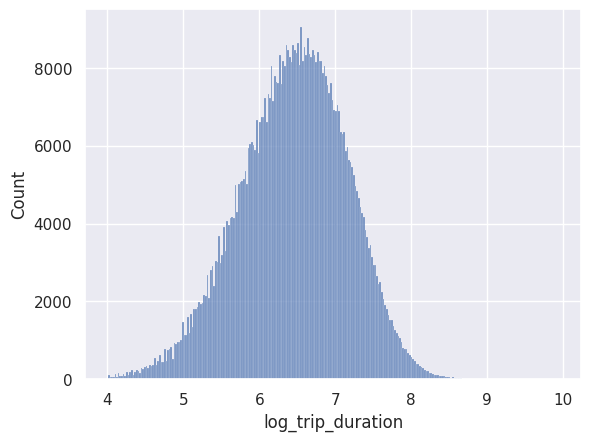

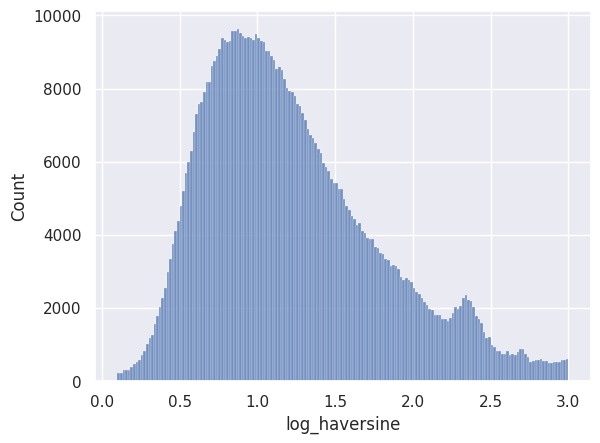

In [ ]:
sns.histplot(data_cleaned['log_trip_duration'])
plt.show()

sns.histplot(data_cleaned['log_haversine'])
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 705400 entries, 0 to 729321
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     705400 non-null  object        
 1   pickup_datetime        705400 non-null  datetime64[ns]
 2   pickup_longitude       705400 non-null  float64       
 3   pickup_latitude        705400 non-null  float64       
 4   dropoff_longitude      705400 non-null  float64       
 5   dropoff_latitude       705400 non-null  float64       
 6   log_trip_duration      705400 non-null  float64       
 7   day_of_year            705400 non-null  int32         
 8   day_of_week            705400 non-null  int32         
 9   hour_of_day            705400 non-null  int32         
 10  hour                   705400 non-null  int32         
 11  month                  705400 non-null  int32         
 12  is_anomalous_period_1  705400 non-null  int64    

In [ ]:
for column in data_cleaned[['day_of_week', 'month', 'is_anomalous_period_1', 'is_anomalous_period_2',
                         'is_rush_hour', 'is_free_road', 'pickup_grid', 'dropoff_grid']]:
    frequency = data_cleaned[column].value_counts()
    print(f"Частота уникальных значений для столбца '{column}':")
    print(frequency)
    print()

Частота уникальных значений для столбца 'day_of_week':
day_of_week
4    108142
5    106998
3    105792
2    101899
1     98107
6     93982
0     90480
Name: count, dtype: int64

Частота уникальных значений для столбца 'month':
month
3    124198
4    121574
5    119858
2    115800
6    113302
1    110668
Name: count, dtype: int64

Частота уникальных значений для столбца 'is_anomalous_period_1':
is_anomalous_period_1
0    691381
1     14019
Name: count, dtype: int64

Частота уникальных значений для столбца 'is_anomalous_period_2':
is_anomalous_period_2
0    704571
1       829
Name: count, dtype: int64

Частота уникальных значений для столбца 'is_rush_hour':
is_rush_hour
0    501110
1    204290
Name: count, dtype: int64

Частота уникальных значений для столбца 'is_free_road':
is_free_road
0    408095
1    297305
Name: count, dtype: int64

Частота уникальных значений для столбца 'pickup_grid':
pickup_grid
818    637326
718     68071
717         1
118         1
817         1
Name: count, dt

In [ ]:
threshold = 100_000

for column in data_cleaned[['pickup_grid', 'dropoff_grid']]:
    counts = data_cleaned[column].value_counts()
    rare_categories = counts[counts < threshold].index
    data_cleaned[column] = data_cleaned[column].replace(rare_categories, 0)

for column in data_cleaned[['pickup_grid', 'dropoff_grid']]:
    print(f"Частота уникальных значений для столбца '{column}':")
    print(data_cleaned[column].value_counts())
    print()

Частота уникальных значений для столбца 'pickup_grid':
pickup_grid
818    637326
0       68074
Name: count, dtype: int64

Частота уникальных значений для столбца 'dropoff_grid':
dropoff_grid
818    616289
0       89111
Name: count, dtype: int64



<ipython-input-77-65fc45bdeb53>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[column] = data_cleaned[column].replace(rare_categories, 0)


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [ ]:
X, y = data_cleaned[['day_of_week', 'month', 'hour', 'day_of_year',
             'is_anomalous_period_1', 'is_anomalous_period_2',
             'hour_of_day', 'log_haversine', 'is_rush_hour',
             'is_free_road', 'pickup_grid', 'dropoff_grid']], data_cleaned['log_trip_duration']

In [ ]:
categorical_features = ['day_of_week', 'month', 'is_anomalous_period_1', 'is_anomalous_period_2',
                         'is_rush_hour', 'is_free_road', 'pickup_grid', 'dropoff_grid']
numeric_features = ['hour', 'day_of_year', 'hour_of_day', 'log_haversine']

encoder = OneHotEncoder()
scaler = StandardScaler()

X_encoded = encoder.fit_transform(X[categorical_features])
X_scaled = scaler.fit_transform(X[numeric_features])

In [ ]:
X_prepared = np.hstack((X_encoded.toarray(), X_scaled))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.3, random_state=42)

In [ ]:
model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}\nR2 score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.1818716705404192
R2 score: 0.6325455865684593


**Задание 14**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
num_features_before = data_cleaned[['day_of_week', 'month', 'is_anomalous_period_1', 'is_anomalous_period_2',
                         'is_rush_hour', 'is_free_road', 'pickup_grid', 'dropoff_grid']].shape[1]

df_encoded = pd.get_dummies(data_cleaned[['day_of_week', 'month', 'is_anomalous_period_1', 'is_anomalous_period_2',
                         'is_rush_hour', 'is_free_road', 'pickup_grid', 'dropoff_grid']])

num_features_after = df_encoded.shape[1]

print("Количество признаков до кодирования:", num_features_before)
print("Количество признаков после кодирования:", num_features_after)

Количество признаков до кодирования: 8
Количество признаков после кодирования: 8


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
X, y = data_cleaned[['day_of_week', 'month', 'hour', 'day_of_year',
             'is_anomalous_period_1', 'is_anomalous_period_2',
             'hour_of_day', 'log_haversine', 'is_rush_hour',
             'is_free_road', 'pickup_grid', 'dropoff_grid']], data_cleaned['log_trip_duration']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(X_train, y_train)

y_pred_val_lasso = lasso.predict(X_val)

mse_val_lasso = mean_squared_error(y_val, y_pred_val_lasso)
print(f'Mean Squared Error: {mse_val_lasso}\nR2 score: {r2_score(y_val, y_pred_val_lasso)}')

Mean Squared Error: 0.4702189802892298
R2 score: 0.04750068683618047


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.logspace(-3, 3, 100)}

lasso = Lasso()

grid_search_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_lasso.fit(X_train, y_train)

best_alpha_lasso = grid_search_lasso.best_params_['alpha']

best_lasso = grid_search_lasso.best_estimator_
best_lasso.fit(X_train, y_train)

y_pred_val_best_lasso = best_lasso.predict(X_val)

mse_val_best_lasso = mean_squared_error(y_val, y_pred_val_best_lasso)
print(f'Mean Squared Error: {mse_val_lasso}\nR2 score: {r2_score(y_val, y_pred_val_lasso)}')

Mean Squared Error: 0.4702189802892298
R2 score: 0.04750068683618047


In [ ]:
ridge = Ridge()

ridge.fit(X_train, y_train)

y_pred_val_ridge = ridge.predict(X_val)

mse_val_ridge = mean_squared_error(y_val, y_pred_val_ridge)

grid_search_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_ridge.fit(X_train, y_train)

best_alpha_ridge = grid_search_ridge.best_params_['alpha']

best_ridge = grid_search_ridge.best_estimator_
best_ridge.fit(X_train, y_train)

y_pred_val_best_ridge = best_ridge.predict(X_val)

mse_val_best_ridge = mean_squared_error(y_val, y_pred_val_best_ridge)
print(f'Mean Squared Error: {mse_val_best_ridge}\nR2 score: {r2_score(y_val, y_pred_val_best_ridge)}')

Mean Squared Error: 0.18542174321928723
R2 score: 0.6244003528879787


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

Text(0, 0.5, 'Zero Weights')

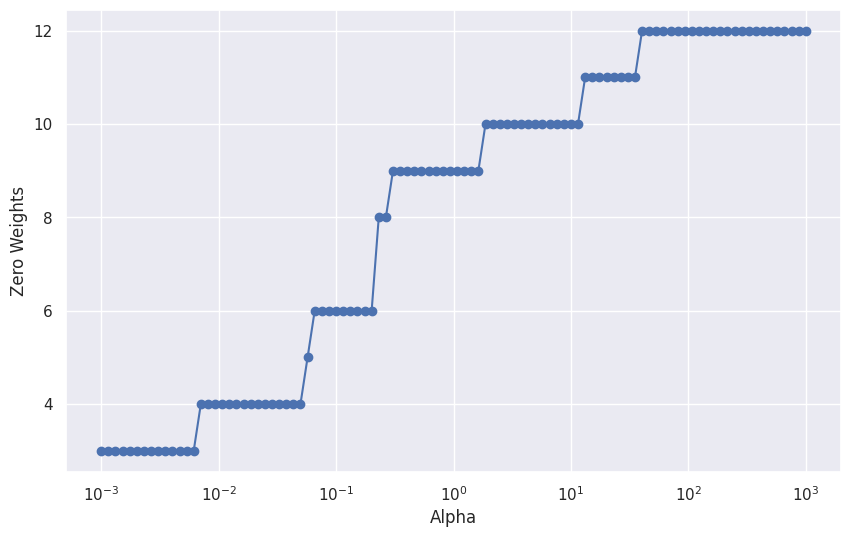

In [ ]:
alphas = np.logspace(-3, 3, 100)

zero_weights_count = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    zero_weights_count.append(np.sum(lasso.coef_ == 0))

plt.figure(figsize=(10, 6))
plt.plot(alphas, zero_weights_count, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Zero Weights')

In [ ]:
num_features = len(X_train.columns)

half_num_features = num_features / 2

alpha_half_zero_weights = alphas[np.argmax(np.array(zero_weights_count) > half_num_features)]

print("Значение alpha:", alpha_half_zero_weights)

Значение alpha: 0.23101297000831605


In [ ]:
lasso_half_zero_weights = Lasso(alpha=alpha_half_zero_weights)

lasso_half_zero_weights.fit(X_train, y_train)

y_pred_val_lasso_half_zero_weights = lasso_half_zero_weights.predict(X_val)

mse_val_lasso_half_zero_weights = mean_squared_error(y_val, y_pred_val_lasso_half_zero_weights)

print(f'Mean Squared Error: {mse_val_lasso_half_zero_weights}\nR2 score: {r2_score(y_val, y_pred_val_lasso_half_zero_weights)}')

Mean Squared Error: 0.3875605264475681
R2 score: 0.21493782530077032


In [ ]:
print("MSE на валидационной выборке для Lasso с лучшим alpha:", mse_val_best_lasso)
print("MSE на валидационной выборке для Ridge с лучшим alpha:", mse_val_best_ridge)
print("MSE на валидационной выборке для Lasso с alpha, где количество нулевых весов превышает половину общего количества признаков:", mse_val_lasso_half_zero_weights)

MSE на валидационной выборке для Lasso с лучшим alpha: 0.1854816558089185
MSE на валидационной выборке для Ridge с лучшим alpha: 0.18542174321928723
MSE на валидационной выборке для Lasso с alpha, где количество нулевых весов превышает половину общего количества признаков: 0.3875605264475681


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
from collections import Counter

cell_pairs = list(zip(data_cleaned['pickup_grid'], data_cleaned['dropoff_grid']))
most_common_pairs = Counter(cell_pairs).most_common(100)

pair_dict = {pair: i for i, (pair, count) in enumerate(most_common_pairs)}

def encode_pair(row):
    pair = (row['pickup_grid'], row['dropoff_grid'])
    return pair_dict.get(pair, -1)

data_cleaned['common_pair'] = data_cleaned.apply(encode_pair, axis=1)

<ipython-input-94-c698ab69dd9a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['common_pair'] = data_cleaned.apply(encode_pair, axis=1)


In [ ]:
data_cleaned['common_pair'].unique()

array([0, 1, 2, 3])

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
X, y = data_cleaned[['day_of_week', 'month', 'hour', 'day_of_year',
             'is_anomalous_period_1', 'is_anomalous_period_2',
             'hour_of_day', 'log_haversine', 'is_rush_hour',
             'is_free_road', 'pickup_grid', 'dropoff_grid', 'common_pair']], data_cleaned['log_trip_duration']

In [ ]:
categorical_features = ['day_of_week', 'month', 'is_anomalous_period_1', 'is_anomalous_period_2',
                         'is_rush_hour', 'is_free_road', 'pickup_grid', 'dropoff_grid', 'common_pair']
numeric_features = ['hour', 'day_of_year', 'hour_of_day', 'log_haversine']

encoder = OneHotEncoder()
scaler = StandardScaler()

X_encoded = encoder.fit_transform(X[categorical_features])
X_scaled = scaler.fit_transform(X[numeric_features])

In [ ]:
X_prepared = np.hstack((X_encoded.toarray(), X_scaled))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.3, random_state=42)

In [ ]:
model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [ ]:
# Прогнозы и оценка
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}\nR2 score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.18183277359499578
R2 score: 0.6326241741473955


**Задание 16 (бонус)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
def manhattan_distance(x1, y1, x2, y2):
    return np.abs(x1 - x2) + np.abs(y1 - y2)

data_cleaned['manhattan_distance'] = manhattan_distance(data_cleaned['pickup_longitude'], data_cleaned['pickup_latitude'],
                                              data_cleaned['dropoff_longitude'], data_cleaned['dropoff_latitude'])

data_cleaned['log_manhattan_distance'] = np.log1p(data_cleaned['manhattan_distance'])

<ipython-input-126-31cbd45d6e48>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['manhattan_distance'] = manhattan_distance(data_cleaned['pickup_longitude'], data_cleaned['pickup_latitude'],
<ipython-input-126-31cbd45d6e48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['log_manhattan_distance'] = np.log1p(data_cleaned['manhattan_distance'])


In [ ]:
correlation_manhattan = data_cleaned['manhattan_distance'].corr(data_cleaned['log_trip_duration'])
correlation_log_manhattan = data_cleaned['log_manhattan_distance'].corr(data_cleaned['log_trip_duration'])

print(f"Корреляция между манхэттенским расстоянием и целевой переменной: {correlation_manhattan}")
print(f"Корреляция между логарифмом манхэттенского расстояния и целевой переменной: {correlation_log_manhattan}")

Корреляция между манхэттенским расстоянием и целевой переменной: 0.6512647177923718
Корреляция между логарифмом манхэттенского расстояния и целевой переменной: 0.6621730606788458


In [ ]:
import numpy as np
import pandas as pd
import folium

def show_axes_on_map(data, latitude_column, longitude_column):
    location = [data[latitude_column].mean(), data[longitude_column].mean()]
    m = folium.Map(location=location, zoom_start=12)

    folium.PolyLine(locations=[
        [data[latitude_column].min(), data[longitude_column].mean()],
        [data[latitude_column].max(), data[longitude_column].mean()]
    ], color='blue', weight=2.5, opacity=1).add_to(m)

    folium.PolyLine(locations=[
        [data[latitude_column].mean(), data[longitude_column].min()],
        [data[latitude_column].mean(), data[longitude_column].max()]
    ], color='red', weight=2.5, opacity=1).add_to(m)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color='green',
            fill=True
        ).add_to(m)

    return m

map_with_axes = show_axes_on_map(data_cleaned.sample(1000), 'pickup_latitude', 'pickup_longitude')
map_with_axes

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
X, y = data_cleaned[['day_of_week', 'month', 'hour', 'day_of_year',
             'is_anomalous_period_1', 'is_anomalous_period_2',
             'hour_of_day', 'is_rush_hour',
             'is_free_road', 'pickup_grid', 'dropoff_grid', 'common_pair', 'log_manhattan_distance']], data_cleaned['log_trip_duration']

In [ ]:
categorical_features = ['day_of_week', 'month', 'is_anomalous_period_1', 'is_anomalous_period_2',
                         'is_rush_hour', 'is_free_road', 'pickup_grid', 'dropoff_grid', 'common_pair']
numeric_features = ['hour', 'day_of_year', 'hour_of_day', 'log_manhattan_distance']

encoder = OneHotEncoder()
scaler = StandardScaler()

X_encoded = encoder.fit_transform(X[categorical_features])
X_scaled = scaler.fit_transform(X[numeric_features])

In [ ]:
X_prepared = np.hstack((X_encoded.toarray(), X_scaled))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.3, random_state=42)

In [ ]:
model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}\nR2 score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.25807926642252593
R2 score: 0.4785753868079414


**Задание 17 (бонус)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ